# Bengio's Neural Probabilistic Language Model

## Name: Rafael Gonçalves

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import torch
from torch.utils.data import TensorDataset, DataLoader

from math import ceil
from itertools import islice
from collections import Counter
from multiprocessing import cpu_count

In [2]:
# Notebook options
reproducible = True
use_cuda = True

## Config

In [3]:
# Make it reproducible
if reproducible:
  seed = 0
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [4]:
# GPU acceleration
if torch.cuda.is_available() and use_cuda:
  dev = "cuda:0"
  device_name = torch.cuda.get_device_name(dev)
else:
  dev = "cpu"
  device_name = "cpu"

device = torch.device(dev)
dev, device_name

('cuda:0', 'Tesla P100-PCIE-16GB')

In [5]:
# CPU info
n_cpu = cpu_count()
n_cpu

2

In [6]:
# Matplotlib
style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 7.5)

## Download dataset wikitext 2

In [7]:
!wget -nc https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -o wikitext-2-v1.zip

--2020-03-25 15:38:22--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.205.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.205.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  --.-KB/s    in 0.1s    

2020-03-25 15:38:22 (40.6 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


## Tokenization

In [8]:
def load_tokens(path):
  """Create a list of tokens from file in path."""
  text = open(path).read().lower()
  return text.split()
    

def build_vocab(tokens, vocab_size):
  """Create dict with the vocab_size most common tokens in tokens.""" 
  word_frequency = Counter(tokens)

  vocab = {token: index for index, (token, _) in enumerate(
    word_frequency.most_common(vocab_size))}

  if '<unk>' not in vocab:
    vocab['<unk>'] = len(vocab)

  if '<pad>' not in vocab:
    vocab['<pad>'] = len(vocab)

  return vocab 

In [9]:
# Load tokens
train_tokens = load_tokens('wikitext-2/wiki.train.tokens')
valid_tokens = load_tokens('wikitext-2/wiki.valid.tokens')
test_tokens = load_tokens('wikitext-2/wiki.test.tokens')
len(train_tokens), len(valid_tokens), len(test_tokens)

(2051910, 213886, 241211)

In [10]:
print(train_tokens[100:110])

[',', 'a', 'penal', 'military', 'unit', 'serving', 'the', 'nation', 'of', 'gallia']


In [11]:
# Separate mini dataset for cv and real dataset for evaluation
mini_train_tokens = train_tokens[:100_000]
mini_valid_tokens = valid_tokens[:10_000]

In [12]:
# Build vocab
max_vocab_size = 10_000
vocab = build_vocab(train_tokens, vocab_size=max_vocab_size)
vocab_size = len(vocab)
print(f'Vocab has {vocab_size} tokens')
print(f'10 sample tokens: {list(islice(vocab.keys(), 10))}')

Vocab has 10001 tokens
10 sample tokens: ['the', ',', '.', 'of', '<unk>', 'and', 'in', 'to', 'a', '=']


## Create ngrams (context)

In [13]:
def create_ngrams(tokens, vocab, n):
  """Create ngrams tensors x and y with context n from tokens using vocab."""
  X, y = [], []
  padding = ('<pad> '*(n-1)).split()
  tokens = [*padding, *tokens]
  for i, word in enumerate(tokens[:-n]):
    x = []
    for j in range(i, i+n):
      if tokens[j] in vocab.keys():
        x.append(vocab[tokens[j]])
      else:
        x.append(vocab['<unk>'])

    X.append(x)
    if tokens[i+n] in vocab.keys():
      y.append(vocab[tokens[i+n]])
    else:
      y.append(vocab['<unk>'])
  
  return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)
      

In [14]:
# Retrieve words from tokens
vocab_rev=dict([reversed(i) for i in vocab.items()])

In [15]:
# Mini datasets
x, y = create_ngrams(mini_train_tokens, vocab, 5)
x_val, y_val = create_ngrams(mini_valid_tokens, vocab, 5)
x, y

(tensor([[10000, 10000, 10000, 10000,     9],
         [10000, 10000, 10000,     9,  3815],
         [10000, 10000,     9,  3815,  3878],
         ...,
         [    2,     0,     4,    28,  8851],
         [    0,     4,    28,  8851,    24],
         [    4,    28,  8851,    24,  2365]]),
 tensor([3815, 3878,  884,  ...,   24, 2365,   42]))

In [16]:
print(x.shape, x.type())
print(y.shape, y.type())

torch.Size([99999, 5]) torch.LongTensor
torch.Size([99999]) torch.LongTensor


In [17]:
# Example ngrams
for e in x[:10]:
  for f in e:
    print(vocab_rev[int(f)], end=" ")
  print("")

<pad> <pad> <pad> <pad> = 
<pad> <pad> <pad> = valkyria 
<pad> <pad> = valkyria chronicles 
<pad> = valkyria chronicles iii 
= valkyria chronicles iii = 
valkyria chronicles iii = <unk> 
chronicles iii = <unk> no 
iii = <unk> no valkyria 
= <unk> no valkyria 3 
<unk> no valkyria 3 : 


In [18]:
# Dataset for validation
mini_train_dataset = TensorDataset(x, y)
mini_valid_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(mini_train_dataset, batch_size=1000, shuffle=True, num_workers=n_cpu, pin_memory=True)
test_loader = DataLoader(mini_valid_dataset, batch_size=10000, shuffle=False, num_workers=n_cpu, pin_memory=True)

## One-hot encoded embeddings implementation


In [19]:
def one_hot_encode(x, vocab_size):
  """Return tensor x one-hot encoded."""
  x_0, x_1 = x.shape[0:2]
  ones = torch.eye(vocab_size)
  ones = ones.index_select(0, x.view(-1))
  return ones.view(x_0, x_1, -1)

class OneHotEmbedding(torch.nn.Module):
  """Module that computes embedding using dot product."""

  def __init__(self, vocab_size, embedding_dim):
    super(OneHotEmbedding, self).__init__()
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.embedding = torch.nn.Linear(vocab_size, embedding_dim, bias=False)

  def forward(self, x):
    x = one_hot_encode(x.to('cpu'), self.vocab_size).to(device)
    x = self.embedding(x)
    return x

## Model

In [20]:
class LanguageModel(torch.nn.Module):
  """Bengio Language Model where p = softmax(b + Wx + Utanh(d + Hx)).
  In this case the net outputs logits, without softmax activation."""

  def __init__(self, vocab_size, hidden_dim, embedding_dim, context_size=5,
               activation=torch.nn.Tanh(), use_direct=False, one_hot_emb=False):
    super(LanguageModel, self).__init__()

    self.use_direct = use_direct
    self.wordvecs_size = embedding_dim*context_size
    out_dim = hidden_dim + self.wordvecs_size if self.use_direct else hidden_dim

    if one_hot_emb:
      self.embedding = OneHotEmbedding(vocab_size, embedding_dim)
    else:
      self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
    
    self.layer1 = torch.nn.Linear(embedding_dim*context_size, hidden_dim)
    self.activation = activation
    self.layer2 = torch.nn.Linear(out_dim, vocab_size)

  def forward(self, x):
    a = self.embedding(x)
    a = a.reshape(-1, self.wordvecs_size)
    u = self.layer1(a)
    u = self.activation(u)
    u = torch.cat((u, a), dim=-1) if self.use_direct else u
    logits = self.layer2(u)

    if not self.training:
      logits[:,vocab['<pad>']] = 0
      logits[:,vocab['<unk>']] = 0

    return logits

In [21]:
def train(epoch, model, optimizer, criterion=torch.nn.CrossEntropyLoss(), v=False):
  """Training routine for model. Outputs vector of training losses."""
  model.train()
  train_loss = []
  log_interval = ceil(len(train_loader)/10)
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    y_logits = model(data)
    loss = criterion(y_logits, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx - 1) * train_loader.batch_size + len(data),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

  return train_loss

In [22]:
def test(model, optimizer, criterion=torch.nn.CrossEntropyLoss(), v=True):
  """Testing routine for model. Outputs test loss."""
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data = data.to(device)
      target = target.to(device)
      y_logits = model(data)
      loss = criterion(y_logits, target)
      test_loss += loss.item()
  test_loss /= len(test_loader)

  if v:
      print('Test set: Loss: {:.4f}'.format(test_loss))


  return test_loss

## Testing model

### 1) Single input

In [23]:
model = LanguageModel(vocab_size, 50, 30).to(device); model

LanguageModel(
  (embedding): Embedding(10001, 30)
  (layer1): Linear(in_features=150, out_features=50, bias=True)
  (activation): Tanh()
  (layer2): Linear(in_features=50, out_features=10001, bias=True)
)

In [24]:
x, y = train_loader.dataset[:1]
x, y

(tensor([[10000, 10000, 10000, 10000,     9]]), tensor([3815]))

In [25]:
y_hat = model(x.to(device)); y_hat

tensor([[ 0.1308,  0.1784,  0.1899,  ..., -0.2909, -0.3157, -0.0362]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [26]:
torch.nn.CrossEntropyLoss()(y_hat, y.to(device))

tensor(9.3121, device='cuda:0', grad_fn=<NllLossBackward>)

### 2-a) One-hot embedding


In [27]:
model = LanguageModel(vocab_size, 50, 30, one_hot_emb=True).to(device); model

LanguageModel(
  (embedding): OneHotEmbedding(
    (embedding): Linear(in_features=10001, out_features=30, bias=False)
  )
  (layer1): Linear(in_features=150, out_features=50, bias=True)
  (activation): Tanh()
  (layer2): Linear(in_features=50, out_features=10001, bias=True)
)

In [28]:
y_hat = model(x.to(device)); y_hat

tensor([[ 0.0221, -0.0231, -0.0363,  ..., -0.0536,  0.1199,  0.1230]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [29]:
torch.nn.CrossEntropyLoss()(y_hat, y.to(device))

tensor(9.1295, device='cuda:0', grad_fn=<NllLossBackward>)

### 2-b) Train Loop (OneHotEmbedding)

In [30]:
model = LanguageModel(vocab_size, 50, 30, activation=torch.nn.ReLU(), one_hot_emb=True).to(device)
opt = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9)
model

LanguageModel(
  (embedding): OneHotEmbedding(
    (embedding): Linear(in_features=10001, out_features=30, bias=False)
  )
  (layer1): Linear(in_features=150, out_features=50, bias=True)
  (activation): ReLU()
  (layer2): Linear(in_features=50, out_features=10001, bias=True)
)

In [31]:
test(model, opt)
for epoch in range(1, 2):
  train(epoch, model, opt, v=True)
  print('')
_ = test(model, opt)

Test set: Loss: 9.2150
Train Epoch: 1 [0/99999 (0%)]	Loss: 9.208900
Train Epoch: 1 [10000/99999 (10%)]	Loss: 9.106755
Train Epoch: 1 [20000/99999 (20%)]	Loss: 8.894740
Train Epoch: 1 [30000/99999 (30%)]	Loss: 8.408447
Train Epoch: 1 [40000/99999 (40%)]	Loss: 7.685940
Train Epoch: 1 [50000/99999 (50%)]	Loss: 7.166727
Train Epoch: 1 [60000/99999 (60%)]	Loss: 7.081440
Train Epoch: 1 [70000/99999 (70%)]	Loss: 6.839503
Train Epoch: 1 [80000/99999 (80%)]	Loss: 6.639837
Train Epoch: 1 [90000/99999 (90%)]	Loss: 6.655239

Test set: Loss: 7.1974


### 3) Learning curve (torch.nn.Embedding)

In [32]:
# Learning curve and accuracy graphs
model = LanguageModel(vocab_size, 50, 30, activation=torch.nn.Tanh()).to(device)
opt = torch.optim.SGD(model.parameters(), 0.1, momentum=0.9)

test(model, opt)
train_loss_l = []
test_loss_l = []

for epoch in range(1, 11):
  train_loss = train(epoch, model, opt)
  test_loss = test(model, opt, v = True)
  train_loss_l.append(np.mean(train_loss))
  test_loss_l.append(test_loss)

Test set: Loss: 9.2320
Test set: Loss: 7.0414
Test set: Loss: 6.8750
Test set: Loss: 6.7903
Test set: Loss: 6.7372
Test set: Loss: 6.7039
Test set: Loss: 6.6816
Test set: Loss: 6.6641
Test set: Loss: 6.6418
Test set: Loss: 6.6265
Test set: Loss: 6.6183


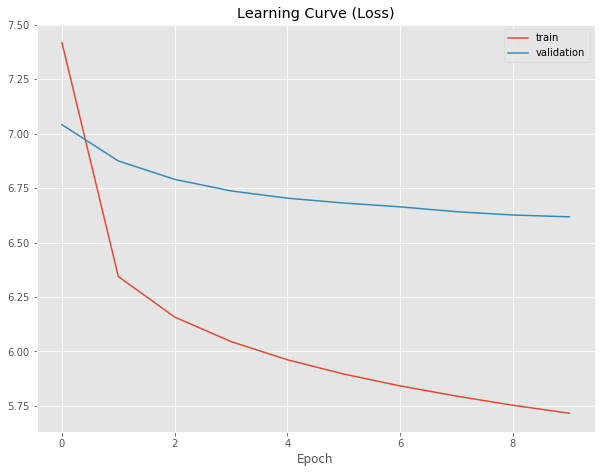

In [33]:
# Visualization of learning curves
plt.plot(train_loss_l)
plt.plot(test_loss_l)
plt.legend(['train', 'validation'])
plt.xlabel('Epoch')
plt.title('Learning Curve (Loss)')
plt.show()

## Perplexity

In [34]:
def ppl(cross_entropy_loss):
  """Calculates perplexity for a given cross entropy loss."""
  return np.exp(cross_entropy_loss)

## Validation with hold out (for hyperparameter tunning)

In [35]:
# Hyperparams options
epochs = 10
learning_rate_params = [0.01, 0.05, 0.1, 0.5]
momentum_params = [0, 0.9]
hidden_layer_params = [50, 100]
embedding_dim_params = [30, 60]
use_direct = [True, False]
activation_params = [torch.nn.Tanh(), torch.nn.ReLU()]

In [37]:
# Wrapper
i = 0
print("Model idx\tH\tM\tDirect\tf(.)\tLoss\tPPL\tEpoch\tLR\tMome")
print("="*100)
for hidden in hidden_layer_params:
  for embedding in embedding_dim_params:
    for direct in use_direct:
      for activation in activation_params:

        best_loss = 999

        model = LanguageModel(vocab_size, hidden, embedding,
                              activation=activation, use_direct=direct).to(device)

        for learning_rate in learning_rate_params:
          for momentum in momentum_params:

            opt = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                  momentum=momentum)

            for epoch in range(1, epochs+1):
              train(epoch, model, opt)
              loss = test(model, opt, v=False)
              if (loss < best_loss):
                best_loss, best_ppl = loss, ppl(loss)
                best_lr, best_momentum, best_epoch = learning_rate, momentum, epoch

        print(f'Model {i}:\t{hidden}\t{embedding}\t{direct}\t{activation}\t{best_loss:5.4f}\t{best_ppl:5.1f}\t{best_epoch}\t{best_lr}\t{best_momentum}')
        i += 1
      

Model idx	H	M	Direct	f(.)	Loss	PPL	Epoch	LR	Mome
Model 0:	50	30	True	Tanh()	6.6763	793.4	7	0.1	0
Model 1:	50	30	True	ReLU()	6.7351	841.4	8	0.05	0.9
Model 2:	50	30	False	Tanh()	6.5681	712.0	10	0.5	0
Model 3:	50	30	False	ReLU()	6.7268	834.4	9	0.05	0.9
Model 4:	50	60	True	Tanh()	6.6279	755.9	6	0.05	0.9
Model 5:	50	60	True	ReLU()	6.7134	823.3	4	0.05	0.9
Model 6:	50	60	False	Tanh()	6.5778	719.0	1	0.5	0
Model 7:	50	60	False	ReLU()	6.7234	831.7	6	0.05	0.9
Model 8:	100	30	True	Tanh()	6.6601	780.6	5	0.1	0
Model 9:	100	30	True	ReLU()	6.7390	844.7	4	0.05	0.9
Model 10:	100	30	False	Tanh()	6.5590	705.6	3	0.5	0
Model 11:	100	30	False	ReLU()	6.7352	841.5	6	0.05	0.9
Model 12:	100	60	True	Tanh()	6.6384	763.8	1	0.1	0
Model 13:	100	60	True	ReLU()	6.6928	806.6	3	0.05	0.9
Model 14:	100	60	False	Tanh()	6.5785	719.4	10	0.1	0
Model 15:	100	60	False	ReLU()	6.6996	812.1	5	0.05	0.9


## Best Model

In [38]:
# # Full vocab and full dataset
# vocab = build_vocab(train_tokens, vocab_size=None)
# vocab_size = len(vocab)

x, y = create_ngrams(train_tokens, vocab, 5)
x_val, y_val = create_ngrams(valid_tokens, vocab, 5)
x_test, y_test = create_ngrams(test_tokens, vocab, 5)

train_dataset = TensorDataset(x, y)
valid_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True,
                          num_workers=n_cpu, pin_memory=True)
test_loader = DataLoader(valid_dataset, batch_size=10000, shuffle=False,
                          num_workers=n_cpu, pin_memory=True)

len(train_loader.dataset), len(test_loader.dataset), vocab_size

(2051909, 213885, 10001)

In [39]:
# Learning curve and accuracy graphs
model = LanguageModel(vocab_size, 100, 30, activation=torch.nn.Tanh()).to(device)
opt = torch.optim.SGD(model.parameters(), 0.5, momentum=0)

best_loss = (0, 999)
best_ppl = (0, 9999)
train_loss_l = []
test_loss_l = []
train_ppl_l = []
test_ppl_l = []

ppl_l = []
for epoch in range(0, 50):
  train_loss = train(epoch, model, opt)
  test_loss = test(model, opt, v = False)

  train_ppl, test_ppl = ppl(np.mean(train_loss)), ppl(test_loss)
  train_loss_l.append(np.mean(train_loss))
  test_loss_l.append(test_loss)
  train_ppl_l.append(train_ppl)
  test_ppl_l.append(test_ppl)

  print('.', end='')

  if test_loss < best_loss[1]:
    best_loss = (epoch, test_loss)
  if ppl(test_loss) < best_ppl[1]:
    best_ppl = (epoch, ppl(test_loss))
    torch.save(model.state_dict(), 'model.pth')

..................................................

In [40]:
print(f'Train loss: {np.mean(train_loss):.4f} Test loss: {best_loss[1]:.4f}',
      f'Train PPL: {ppl(np.mean(train_loss)):.2f} Test PPL: {best_ppl[1]:.2f}')

Train loss: 4.9745 Test loss: 5.9455 Train PPL: 144.67 Test PPL: 382.02


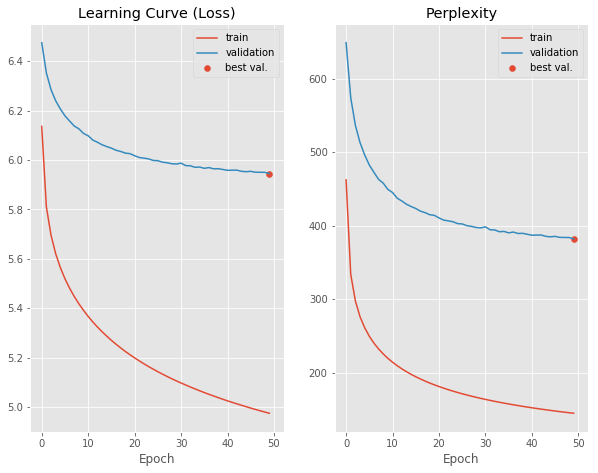

In [41]:
# Visualization of learning curves and perplexity
plt.subplot(1, 2, 1)
plt.plot(train_loss_l)
plt.plot(test_loss_l)
plt.scatter(best_loss[0], best_loss[1])
plt.legend(['train', 'validation', 'best val.'])
plt.xlabel('Epoch')
plt.title('Learning Curve (Loss)')

plt.subplot(1, 2, 2)
plt.plot(train_ppl_l)
plt.plot(test_ppl_l)
plt.scatter(best_ppl[0], best_ppl[1])
plt.legend(['train', 'validation', 'best val.'])
plt.xlabel('Epoch')
plt.title('Perplexity')

plt.show()

### Test dataset

In [42]:
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False,
                          num_workers=n_cpu, pin_memory=True)
len(test_loader.dataset)

241210

In [43]:
def correct(output, target, topk=(1,)):
    """Computes the n of correct guesses over the k top predictions for the specified values of k"""
    # Based on https://github.com/pytorch/examples/blob/master/imagenet/main.py#L407
    with torch.no_grad():
        maxk = max(topk)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        res.append(correct[:k].view(-1).float().sum(0, keepdim=True).item())
        
    return res

In [44]:
model = LanguageModel(vocab_size, 100, 30)
criterion = torch.nn.CrossEntropyLoss()

In [45]:
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)
model.eval()

tops = [1, 5, 10, 30]
correct_l = [0]*len(tops)

In [46]:
test_loss = 0
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.to(device)
    y_logits = model(data)
    loss = criterion(y_logits, target)
    test_loss += loss.item()

    for i, (e, f) in enumerate(zip(correct_l, correct(y_logits, target, tops))):
      correct_l[i] = e + f

test_loss /= len(test_loader)

acc_l = [c/len(test_loader.dataset) for c in correct_l]

print(f'Test loss: {test_loss:.4f}\tTest PPL:{ppl(test_loss):.2f}')
for acc, n in zip(acc_l, tops):
  print(f'Top-{n} accuracy: {acc:.4f}')

Test loss: 5.9497	Test PPL:383.64
Top-1 accuracy: 0.1771
Top-5 accuracy: 0.3422
Top-10 accuracy: 0.4122
Top-30 accuracy: 0.5140


## Testes qualitativos

In [47]:
def word_from_context(words, vocab=vocab, model=model):
  tokens = torch.tensor([vocab[word] if word in vocab.keys() else vocab['<unk>']
                         for word in words ])
  predict = best_model(tokens)
  predict = predict.argmax(dim=1).item()
  return predict

def text_from_text(text, n=5, vocab=vocab, model=model):
  text = text.lower()
  words = text.split()
  for _ in range(n):
    while len(words) < 5:
      words = ["<pad>"] + words
    word = word_from_context(words[-5:], vocab, model)
    words.append(vocab_rev[word])
  return ' '.join(words)

In [49]:
text = "This is a deep learning"
text1 = "The role of the science"
text2 = "Vinicius de Moraes was born"

best_model = model.cpu()

# Predict 10 next words
print(text_from_text(text, n=10))
print('')
print(text_from_text(text1, n=20))
print('')
print(text_from_text(text2, n=100))

this is a deep learning of the city . the first time , the first

the role of the science fiction . the first time the first time . the first time the first time . the first time the

vinicius de moraes was born in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states , the first time in the united states


## Conclusões

*   Apesar de convergir mais rapidamente, usar a função de ativação afim retificada (ReLU) atingiu resultados consistentemente piores que a tanh
*   Na minha implementação as conexões diretas dos embeddings com a camada de saída não melhorou os resultados
*   Meu modelo não convergiu forçando o logitos de `<unk>` para um número negativo uito alto, mas colocá-lo em zero impediu que o modelo chutasse esse valor
*   A implementação do Embedding usando one-hot encoding e camada linear é muito mais lenta do que a implementação `torch.nn.Embedding()`
*   O teste prático do Language Model como gerador de texto não se mostrou muito bom, inclusive entrando em loops.



# End of Notebook